In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import tensorflow as tf
import lime
import tensorflow.keras.preprocessing.image as tf_image
from skimage.io import imread
from IPython.display import Image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input


main_dir = os.path.normpath(os.getcwd())
test_dir = os.path.join(main_dir, 'test')
print(main_dir)

BATCH_SIZE = 60
IMG_SIZE = (224, 224)


print("test: ",test_dir)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\Image Classification Models Comparisons\Lime Library Testing (Inception 95% Accuracy Model)
test:  C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\Image Classification Models Comparisons\Lime Library Testing (Inception 95% Accuracy Model)\test
Found 60 files belonging to 2 classes.


In [2]:
# compare predictions against label batch in test dataset and count how many wrong predictions
def compare_predictions():
    count_all_wrong = 0
    count_acc_wrong = 0
    count_norm_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
        if label_list[i] == 0 and pred_list[i] == 1:
            count_acc_wrong += 1
        if label_list[i] == 1 and pred_list[i] == 0:
            count_norm_wrong += 1
    return print("Total Predictions Wrong: %d, Accidents Predictions Wrong: %d, Normal Predictions Wrong: %d" % 
                 (count_all_wrong, count_acc_wrong, count_norm_wrong))


def compare_predictions_all():
    count_all_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
    return count_all_wrong

def compare_predictions_all_getlist():
    count_all_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
    return wrong_pred_list


def print_wrong_image_predictions():
    plt.figure(figsize=(15, 15))
    for i in range(compare_predictions_all()):
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(image_batch[compare_predictions_all_getlist()[i]].astype("uint8"))
      plt.title(class_names[predictions[compare_predictions_all_getlist()[i]]])
      plt.axis("off")
        
def get_wrong_image(listNum, TorF, numFeat, hideRestValue):
    explainer = lime_image.LimeImageExplainer()
    # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
    explanation = explainer.explain_instance(image_batch[compare_predictions_all_getlist()[listNum]].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=TorF, num_features=numFeat, hide_rest=hideRestValue)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

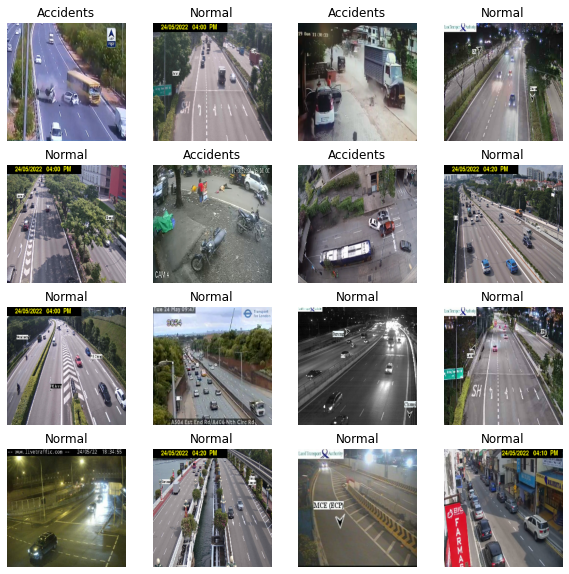

In [3]:
class_names = test_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Configure the Dataset For Performance

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [35]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = tf_image.load_img(img_path, target_size=(224, 224))
        x = tf_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

# Load the InceptionV3 Model that we trained

In [6]:
loaded_model = tf.keras.models.load_model(os.getcwd())
print("Model loaded:", loaded_model)

Model loaded: <keras.engine.functional.Functional object at 0x00000265065469A0>


In [10]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

Predictions:
 [0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1
 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0]
Labels:
 [0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1
 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0]


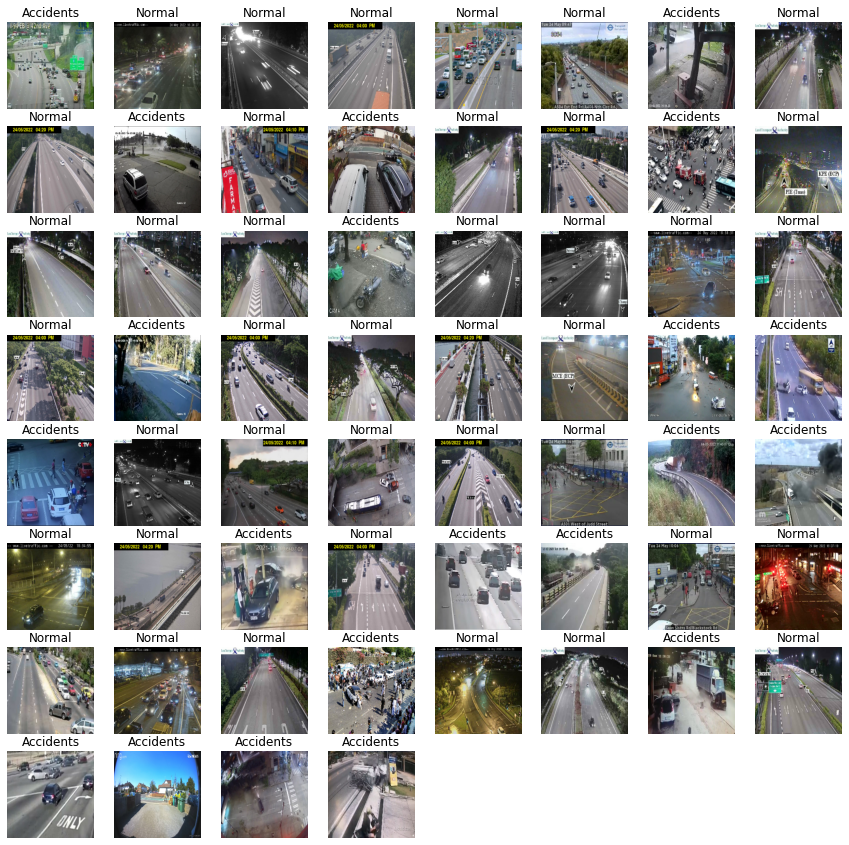

In [11]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = loaded_model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(15, 15))
for i in range(60):
  ax = plt.subplot(8, 8, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [12]:
compare_predictions()

Total Predictions Wrong: 1, Accidents Predictions Wrong: 1, Normal Predictions Wrong: 0


In [13]:
loss, accuracy = loaded_model.evaluate(test_dataset)

1/1 [==============================] - 3s 3s/step - loss: 0.0939 - accuracy: 0.9500


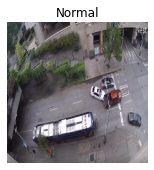

In [14]:
print_wrong_image_predictions()

# See what's the model seeing in the wrong prediction

In [ ]:
get_wrong_image(0, False, 20, False)

In [ ]:
get_wrong_image_cont(False, 20, False)

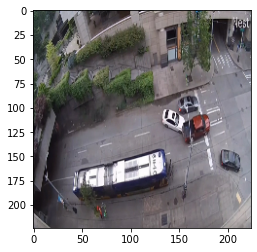

In [26]:
plt.imshow(image_batch[compare_predictions_all_getlist()[0]].astype("uint8"))

In [ ]:
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image_batch[compare_predictions_all_getlist()[0]].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp4, mask4 = explanation_accident_90.get_image_and_mask(explanation_accident_90.top_labels[0], positive_only=True, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp4 / 2 + 0.5, mask4))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation_accident_90.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_accident_90.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_accident_90.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
loss1, accuracy1 = loaded_model.evaluate(test_dataset)
print("The test accuracy is {} and loss is {}".format(accuracy1, loss1))


In [ ]:
loss2, accuracy2 = loaded_model.evaluate(test_ds)
print("The test accuracy is {} and loss is {}".format(accuracy2, loss2))

# We will find out what the model determines  
# for a picture to be an 'Accident'

In [1]:
acc_dir = os.path.join(test_dir, 'Accidents')
acc_img = os.path.join(acc_dir, 'accident_103.jpg')
print(normal_img)
acc_transformed = transform_img_fn([acc_img])
plt.imshow(acc_transformed[0] / 2 + 0.5)

NameError: name 'os' is not defined

In [38]:
%%time

explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(acc_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 334ms/step
CPU times: total: 3min 42s
Wall time: 41.1 s


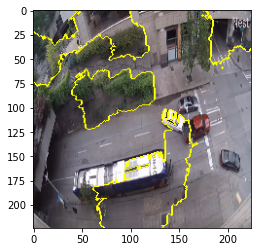

In [39]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

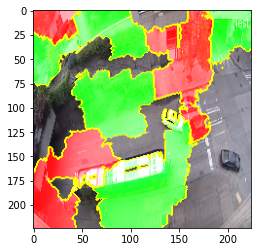

In [40]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

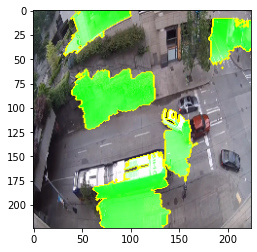

In [42]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

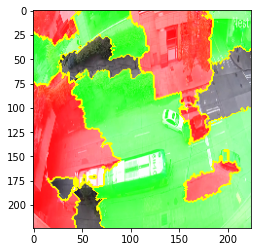

In [44]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=30, hide_rest=False, min_weight=0.0001)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

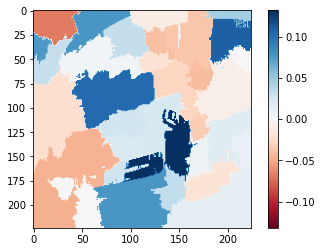

In [45]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

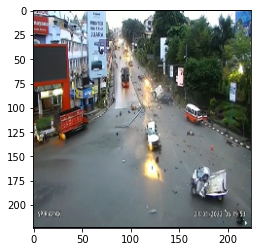

In [86]:
acc33_img = os.path.join(acc_dir, 'accident_97.jpg')
acc33_transformed = transform_img_fn([acc33_img])
plt.imshow(acc33_transformed[0] / 2 + 0.5)

In [87]:
explanation33 = explainer.explain_instance(acc33_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=2, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 470ms/step


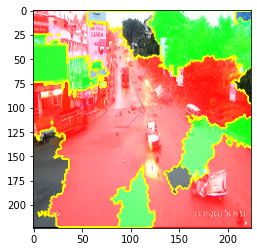

In [98]:
temp1, mask1 = explanation33.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp1 / 2 + 0.5, mask1))

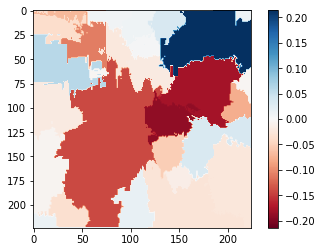

In [94]:
#Select the same class explained on the figures above.
ind33 =  explanation33.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap33 = dict(explanation33.local_exp[ind33])
heatmap33 = np.vectorize(dict_heatmap33.get)(explanation33.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap33, cmap = 'RdBu', vmin  = -heatmap33.max(), vmax = heatmap33.max())
plt.colorbar()

# Next, we will find out about Normal CCTV images

In [ ]:
normal_dir = os.path.join(test_dir, 'Normal')
normal_img = os.path.join(normal_dir, 'normal_175.jpg')
print(normal_img)
normal_transformed = transform_img_fn([normal_img])
plt.imshow(normal_transformed[0] / 2 + 0.5)

In [ ]:
explanation_normal_175 = explainer.explain_instance(normal_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)
temp1, mask1 = explanation_normal_175.get_image_and_mask(0, positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp1 / 2 + 0.5, mask1))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation_normal_175.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_normal_175.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_normal_175.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Take a look at a wrong prediction 
# of a Normal CCTV image

In [ ]:
wrong_pred_normal_img = os.path.join(normal_dir, 'normal_170.jpg')
print(wrong_pred_normal_img)
wrong_pred_normal_transformed = transform_img_fn([wrong_pred_normal_img])
plt.imshow(wrong_pred_normal_transformed[0] / 2 + 0.5)

In [ ]:
explanation_normal_170 = explainer.explain_instance(wrong_pred_normal_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
temp2, mask2 = explanation_normal_170.get_image_and_mask(0, positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation_normal_170.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_normal_170.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_normal_170.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
temp2, mask2 = explanation_normal_170.get_image_and_mask(0, positive_only=False, num_features=3, hide_rest=False)
plt.imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))

# Take a look at a wrong prediction
# of a accident image

In [ ]:
wrong_pred_accident_img = os.path.join(accident_dir, 'accident_91.jpg')
print(wrong_pred_accident_img)
wrong_pred_accident_transformed = transform_img_fn([wrong_pred_accident_img])
plt.imshow(wrong_pred_accident_transformed[0] / 2 + 0.5)

In [ ]:
explanation_accident_91 = explainer.explain_instance(wrong_pred_accident_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
temp3, mask3 = explanation_accident_91.get_image_and_mask(0, positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp3 / 2 + 0.5, mask3))

In [ ]:
temp3, mask3 = explanation_accident_91.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp3 / 2 + 0.5, mask3))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation_accident_91.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_accident_91.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_accident_91.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()